# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████| 60.0K/60.0K [00:44<00:00, 1.36KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

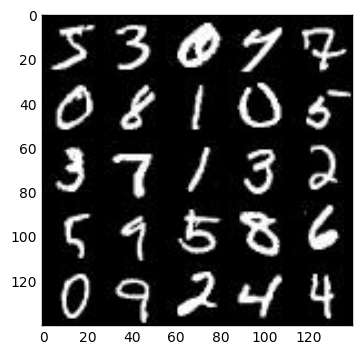

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

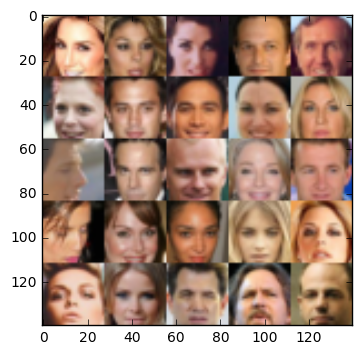

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    im_tensor = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_tensor = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return im_tensor, z_tensor, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2  # Leaky ReLU hyperparameter
    
    # Set scope to allow re-use
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 image
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')  # 14 x 14 x 64 output
        lrelu1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU activation
        
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')  # 7 x 7 x 128 output
        bn1 = tf.layers.batch_normalization(x2, training=True)  # Batch norm
        lrelu2 = tf.maximum(alpha * bn1, bn1)
        
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')  # 4 x 4 x 256 output
        bn2 = tf.layers.batch_normalization(x3, training=True)  # Batch norm
        lrelu3 = tf.maximum(alpha * bn2, bn2)
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))  # Flatten for use in fully connected layer
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2  # Leaky ReLU hyperparameter
    
    # Set scope to allow re-use
    with tf.variable_scope('generator', reuse = not is_train):
        # Start with fully connected layer with input noise
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it for use in transpose convolutional layers
        x1 = tf.reshape(x1, (-1, 7, 7, 512))  # 7 x 7 x 512 output
        bn1 = tf.layers.batch_normalization(x1, training=is_train)  # Batch norm
        lrelu1 = tf.maximum(alpha * bn1, bn1)  # Leaky ReLU activation
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=2, padding='same')  # 14 x 14 x 256 output
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same')  # 28 x 28 x 128 output
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer - strides=1 with same padding here means 28 x 28 x out_channel_dim output
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)  # Tanh activation for final putput of generator
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Get outputs from generator and discriminator
    gen = generator(input_z, out_channel_dim, is_train=True)
    disc_fake_out, disc_fake_logits = discriminator(gen, reuse=False)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=True)
    
    # Calculate losses for each
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits, labels=tf.ones_like(disc_real_out)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=tf.zeros_like(disc_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=tf.ones_like(disc_fake_out)))

    # Discriminator loss is sum of real and fake losses
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases from training variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimizizing
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    tf.reset_default_graph()
    
    # Determine number of image channels
    out_channels = 0
    if data_image_mode == 'RGB':
        out_channels = 3
    else:
        out_channels = 1
    
    images_tensor, z_tensor, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) 
    d_loss, g_loss = model_loss(images_tensor, z_tensor, out_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))  # Generate noise to check sample outputs during training

    # Track steps for determining when to show loss & sample outputs
    steps = 0
    
    # Train the Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1  # Increment steps for each batch

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images_tensor: batch_images, z_tensor: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_tensor: batch_z, images_tensor: batch_images, lr_tensor: learning_rate})

                if steps % 10 == 0:
                    # At the end of a given number of steps, get the losses and print them out
                    train_loss_d = d_loss.eval({z_tensor: batch_z, images_tensor: batch_images})
                    train_loss_g = g_loss.eval({z_tensor: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:  # Show samples every 100 steps
                    _ = show_generator_output(sess, 72, z_tensor, out_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 4.1929
Epoch 1/2... Discriminator Loss: 0.4650... Generator Loss: 2.9022
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 1.7400
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 2.7874
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 2.0344
Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 1.3325


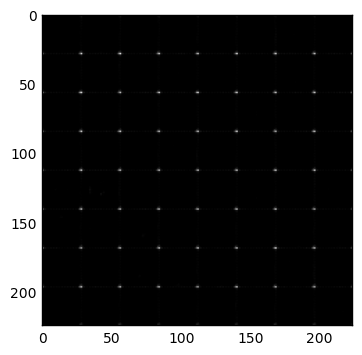

Epoch 1/2... Discriminator Loss: 0.2752... Generator Loss: 1.9995
Epoch 1/2... Discriminator Loss: 0.1490... Generator Loss: 2.8093
Epoch 1/2... Discriminator Loss: 0.1779... Generator Loss: 2.4728
Epoch 1/2... Discriminator Loss: 0.0944... Generator Loss: 4.8980
Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 1.5484
Epoch 1/2... Discriminator Loss: 0.0883... Generator Loss: 3.0961
Epoch 1/2... Discriminator Loss: 0.0461... Generator Loss: 4.1411
Epoch 1/2... Discriminator Loss: 0.0916... Generator Loss: 2.8909
Epoch 1/2... Discriminator Loss: 0.0803... Generator Loss: 3.2751
Epoch 1/2... Discriminator Loss: 0.0415... Generator Loss: 4.1720


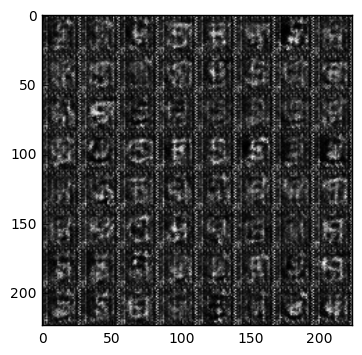

Epoch 1/2... Discriminator Loss: 0.1083... Generator Loss: 2.5579
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 5.5065
Epoch 1/2... Discriminator Loss: 0.0262... Generator Loss: 6.8219
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 4.3517
Epoch 1/2... Discriminator Loss: 0.0200... Generator Loss: 13.9415
Epoch 1/2... Discriminator Loss: 0.0085... Generator Loss: 10.2878
Epoch 1/2... Discriminator Loss: 0.0158... Generator Loss: 4.9511
Epoch 1/2... Discriminator Loss: 0.2467... Generator Loss: 2.6297
Epoch 1/2... Discriminator Loss: 0.1402... Generator Loss: 2.7706
Epoch 1/2... Discriminator Loss: 0.0706... Generator Loss: 5.4814


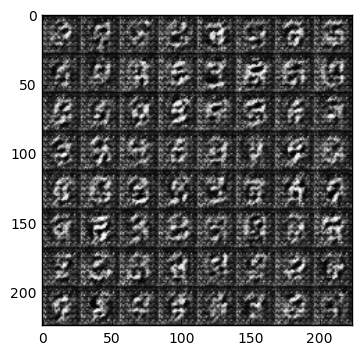

Epoch 1/2... Discriminator Loss: 0.0290... Generator Loss: 4.8450
Epoch 1/2... Discriminator Loss: 0.8827... Generator Loss: 6.9833
Epoch 1/2... Discriminator Loss: 0.0255... Generator Loss: 7.9089
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 0.0059... Generator Loss: 7.2185
Epoch 1/2... Discriminator Loss: 3.0094... Generator Loss: 15.3217
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 4.9025
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 2.7732
Epoch 1/2... Discriminator Loss: 0.5189... Generator Loss: 1.7216


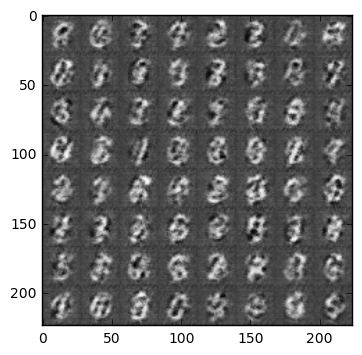

Epoch 1/2... Discriminator Loss: 0.5955... Generator Loss: 3.8364
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 3.6785
Epoch 1/2... Discriminator Loss: 0.2537... Generator Loss: 2.2474
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 3.7753
Epoch 1/2... Discriminator Loss: 0.1685... Generator Loss: 2.9261
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 6.0792
Epoch 2/2... Discriminator Loss: 0.1458... Generator Loss: 3.0807
Epoch 2/2... Discriminator Loss: 0.3229... Generator Loss: 1.6394
Epoch 2/2... Discriminator Loss: 0.2337... Generator Loss: 2.1009


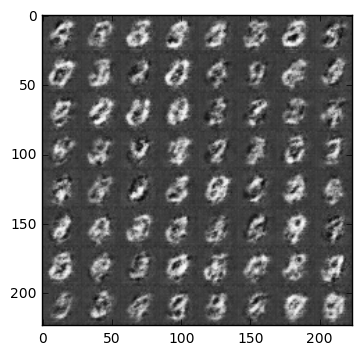

Epoch 2/2... Discriminator Loss: 0.1671... Generator Loss: 3.2824
Epoch 2/2... Discriminator Loss: 0.1688... Generator Loss: 2.8727
Epoch 2/2... Discriminator Loss: 0.2773... Generator Loss: 1.9727
Epoch 2/2... Discriminator Loss: 1.7272... Generator Loss: 0.3019
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 1.7269
Epoch 2/2... Discriminator Loss: 0.2586... Generator Loss: 2.9260
Epoch 2/2... Discriminator Loss: 0.1473... Generator Loss: 2.5294
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 2.0777
Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.1962... Generator Loss: 2.1989


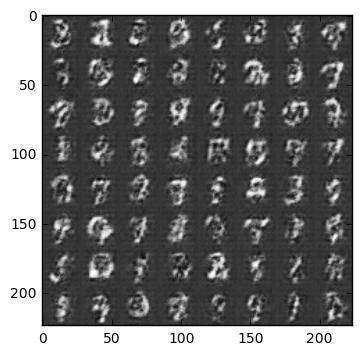

Epoch 2/2... Discriminator Loss: 0.2282... Generator Loss: 1.9978
Epoch 2/2... Discriminator Loss: 0.1662... Generator Loss: 2.9521
Epoch 2/2... Discriminator Loss: 0.1809... Generator Loss: 2.7489
Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 1.6986
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 2.5371
Epoch 2/2... Discriminator Loss: 0.4270... Generator Loss: 1.3274
Epoch 2/2... Discriminator Loss: 0.2061... Generator Loss: 2.3478
Epoch 2/2... Discriminator Loss: 0.1771... Generator Loss: 2.5698
Epoch 2/2... Discriminator Loss: 0.1372... Generator Loss: 3.0283
Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 1.2542


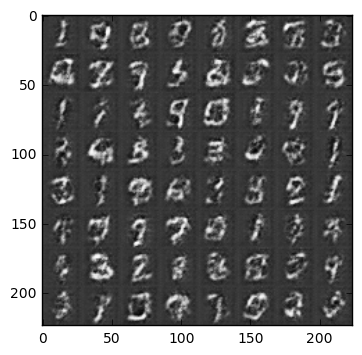

Epoch 2/2... Discriminator Loss: 0.3061... Generator Loss: 1.8700
Epoch 2/2... Discriminator Loss: 0.1817... Generator Loss: 2.4893
Epoch 2/2... Discriminator Loss: 0.1904... Generator Loss: 2.2084
Epoch 2/2... Discriminator Loss: 0.1843... Generator Loss: 2.3593
Epoch 2/2... Discriminator Loss: 0.1112... Generator Loss: 2.6540
Epoch 2/2... Discriminator Loss: 0.1565... Generator Loss: 2.3392
Epoch 2/2... Discriminator Loss: 0.1142... Generator Loss: 2.9211
Epoch 2/2... Discriminator Loss: 0.1346... Generator Loss: 2.9346
Epoch 2/2... Discriminator Loss: 0.1278... Generator Loss: 2.5960
Epoch 2/2... Discriminator Loss: 0.1524... Generator Loss: 2.6202


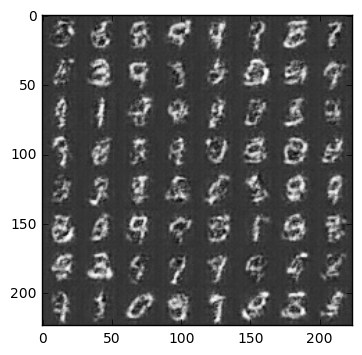

Epoch 2/2... Discriminator Loss: 0.0932... Generator Loss: 3.2496
Epoch 2/2... Discriminator Loss: 0.1311... Generator Loss: 3.3425
Epoch 2/2... Discriminator Loss: 7.5408... Generator Loss: 9.8749
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 1.4379
Epoch 2/2... Discriminator Loss: 0.2803... Generator Loss: 1.9626
Epoch 2/2... Discriminator Loss: 0.2870... Generator Loss: 1.8157
Epoch 2/2... Discriminator Loss: 0.2153... Generator Loss: 2.1580
Epoch 2/2... Discriminator Loss: 0.2709... Generator Loss: 1.8094
Epoch 2/2... Discriminator Loss: 0.3089... Generator Loss: 1.6272


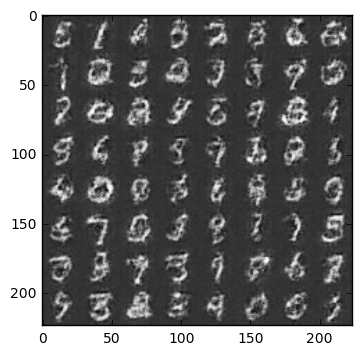

Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 0.1912... Generator Loss: 2.1285
Epoch 2/2... Discriminator Loss: 0.1392... Generator Loss: 2.7377


IndexError: list index out of range

In [56]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 1.7720
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 3.3945
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.2321... Generator Loss: 2.1683
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 4.1304
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 3.9178
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 3.2548


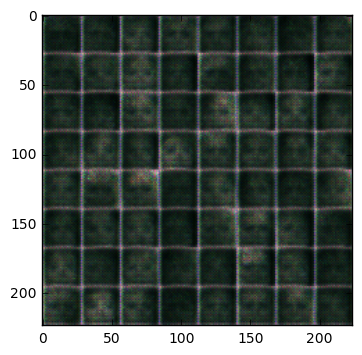

Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 3.4069
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 5.2816
Epoch 1/1... Discriminator Loss: 0.0413... Generator Loss: 8.1762
Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 6.2729
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 6.1508
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 5.4552
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 4.7229
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.3356
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 5.2165
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 6.0891


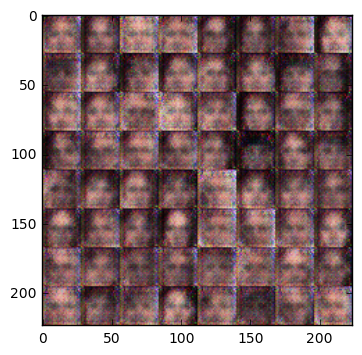

Epoch 1/1... Discriminator Loss: 0.0315... Generator Loss: 4.0304
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 10.3901
Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 3.9211
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 5.8134
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 4.4175
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 7.5273
Epoch 1/1... Discriminator Loss: 0.0802... Generator Loss: 3.3126
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 7.2550
Epoch 1/1... Discriminator Loss: 0.0135... Generator Loss: 7.6932
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 2.2969


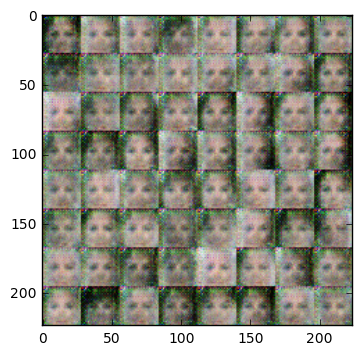

Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 9.8859
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 8.6589
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.6482
Epoch 1/1... Discriminator Loss: 2.8614... Generator Loss: 0.1004
Epoch 1/1... Discriminator Loss: 0.2532... Generator Loss: 3.3624
Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.2884
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 3.5804
Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 4.1931
Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 9.1716
Epoch 1/1... Discriminator Loss: 0.1658... Generator Loss: 2.8483


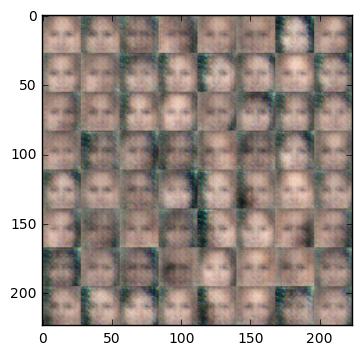

Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 3.2883
Epoch 1/1... Discriminator Loss: 0.1510... Generator Loss: 5.3844
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 4.7378
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 2.4123... Generator Loss: 0.1399
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.5817


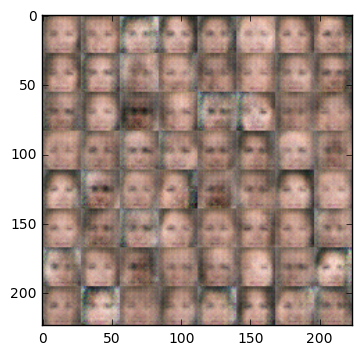

Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 4.6015
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 3.0669
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 0.2073... Generator Loss: 2.9789
Epoch 1/1... Discriminator Loss: 0.3245... Generator Loss: 2.4468


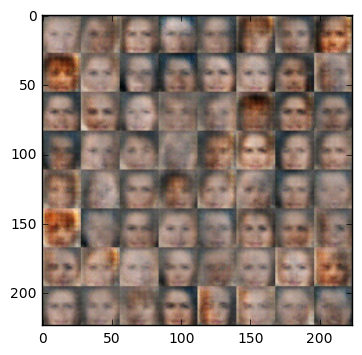

Epoch 1/1... Discriminator Loss: 0.3200... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.2900... Generator Loss: 2.2784
Epoch 1/1... Discriminator Loss: 0.1524... Generator Loss: 4.6344
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 3.8814
Epoch 1/1... Discriminator Loss: 0.2945... Generator Loss: 5.8874
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 9.4521
Epoch 1/1... Discriminator Loss: 0.4294... Generator Loss: 2.1528
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.1485
Epoch 1/1... Discriminator Loss: 0.1586... Generator Loss: 3.2721
Epoch 1/1... Discriminator Loss: 3.1948... Generator Loss: 0.0554


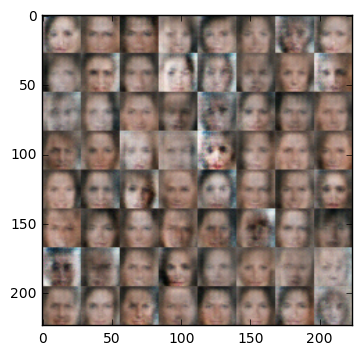

Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 5.6260
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 0.3093... Generator Loss: 5.9913
Epoch 1/1... Discriminator Loss: 0.2643... Generator Loss: 5.1869
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 5.0202
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.2682
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 2.5369
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 4.7301


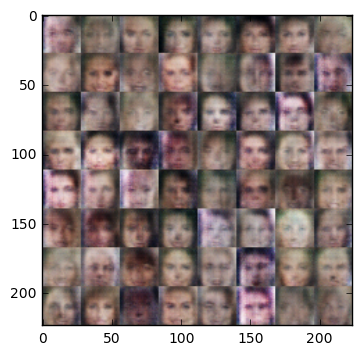

Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 7.5627
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.4898
Epoch 1/1... Discriminator Loss: 3.1755... Generator Loss: 0.0602
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 3.6484
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 6.9056
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 4.4613


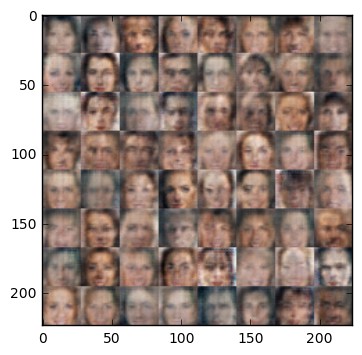

Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 2.1360
Epoch 1/1... Discriminator Loss: 0.2932... Generator Loss: 2.1223
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 3.2762
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.6621
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 4.9580
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 3.7037


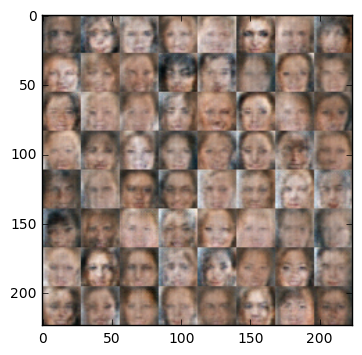

Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 4.0976
Epoch 1/1... Discriminator Loss: 0.1009... Generator Loss: 8.8024
Epoch 1/1... Discriminator Loss: 3.3583... Generator Loss: 3.7864
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 2.3162
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 6.1650
Epoch 1/1... Discriminator Loss: 2.6418... Generator Loss: 1.5948


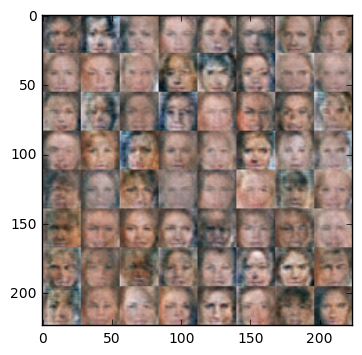

Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8302


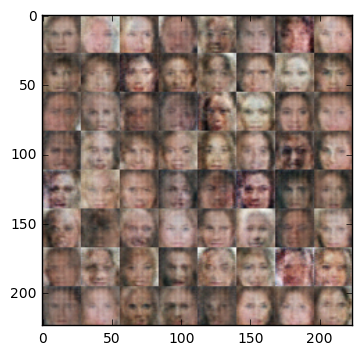

Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.0491


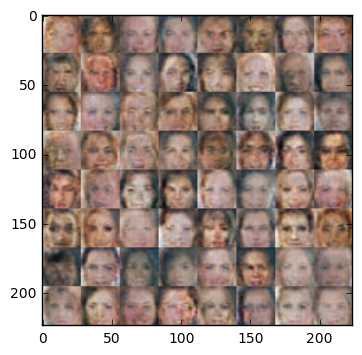

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.3478


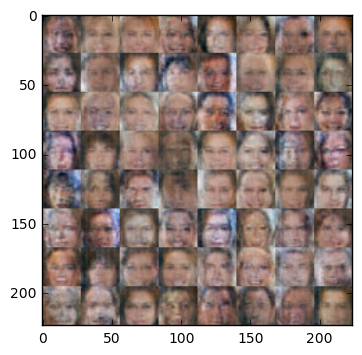

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2826
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 2.0286
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.3141


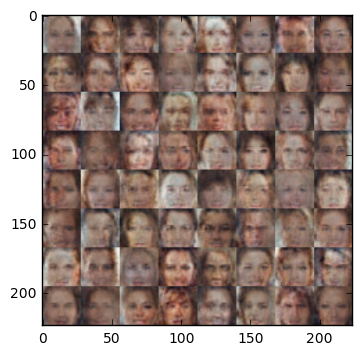

Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.7117


IndexError: list index out of range

In [58]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.